<a href="https://colab.research.google.com/github/mattbarrett98/Hamiltonian-Monte-Carlo/blob/main/MyMC3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# for reading RData file into a pandas dataframe
!pip install pyreadr
import pyreadr

# for fast maths
import numpy as np

# for visualisations
import seaborn as sns
from matplotlib import pyplot as plt

# for autocorrelation plots to monitor efficiency of Markov chains
import statsmodels.graphics.tsaplots

# for normal pdf
import scipy.stats

# for finding maximum likelihood estimate
from scipy.optimize import minimize

# MCMC library to compare results with
import pymc3 as pm
import arviz as az

# for hiding warnings
import warnings
warnings.filterwarnings("ignore")

In [46]:
data = pyreadr.read_r('contracep.RData')
data = data['contracep']
data

,age,total,use
0,18.0,35.0,16.0
1,19.0,27.0,17.0
2,20.0,29.0,12.0
3,21.0,27.0,13.0
4,22.0,35.0,26.0
5,23.0,34.0,23.0
6,24.0,33.0,28.0
7,25.0,26.0,23.0
8,26.0,28.0,26.0
9,27.0,29.0,23.0


We first visualise the data: since we have varying numbers of observations depending on the age, we plot the proportion of women which use contraception, rather than raw figures.

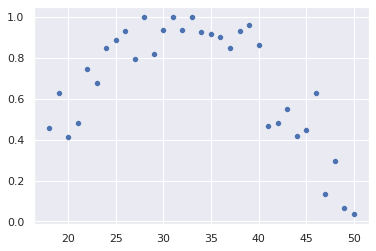

In [47]:
age = np.array(data.age)
use = np.array(data.use)
total = np.array(data.total)
proportion = use / total
data['proportion'] = proportion

sns.set_theme(style='darkgrid')
sns.scatterplot(x=age, y=proportion)

First we will use the Hamiltonian Monte Carlo algorithm with the standard normal as our target distribution to show the algorithm does provide us samples of the correct distribution. To implement HMC we need the negative log of the target density and its gradient, denoted U and grad_U in the function below. The density of the standard normal is $$\pi(x)=\frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}$$and the taking the negative of the natural log of this gives $$-\log\pi(x)=-\log\frac{1}{\sqrt{2\pi}} - \log e^{-\frac{x^2}{2}} = \frac{1}{2}\log 2\pi + \frac{x^2}{2}.$$ The gradient of this is simply $$\frac{d}{dx}-\log\pi(x)=x.$$

0.6134


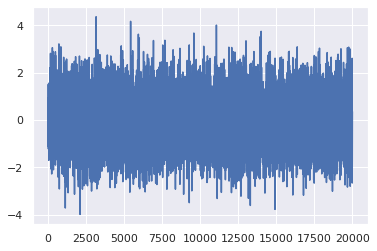

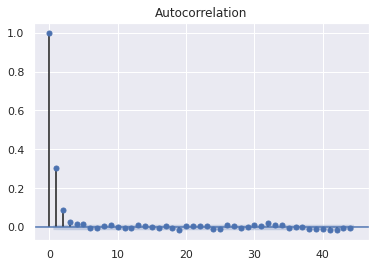

In [13]:
def HMC(U, grad_U, epsilon, L, current_q, n_sim):
    """The Hamiltonian Monte Carlo algorithm. It simulates a Markov chain 
    which has a target distribution of our choosing as its invariant 
    distribution. Hence after the Markov chain has converged to its invariant 
    distribution all subsequent values in the chain will be samples from our 
    target distribution, albeit correlated samples.

    Parameters
    ----------
    U : function which calculates the value of the negative log of our target
    distribution. 

    grad_U : function which calculates the gradient of the function U.

    epsilon : float. The step size used to discretise the differential 
    equations.

    L : int. The number of steps to take in the simulation of the differential
    equations. 

    current_q : The inital value of the Markov chain. 

    n_sim : int. The number of samples to generate.

    Returns
    -------
    samples : an array containing the values from our markov chain. 

    n_accepted : The number of proposals that were accepted. Useful for tuning 
    epsilon and L. 
    """
    samples = []
    n_accepted = 0
    for j in range(n_sim):
        q = current_q
        p = np.random.normal(size=1) 
        current_p = p
        # perform L leapfrog steps
        p = p - epsilon*grad_U(q)/2
        for i in range(L):
            q = q + epsilon*p
            if i != L-1:
                p = p - epsilon*grad_U(q)
        p = p - epsilon*grad_U(q)/2
        p = -p
        # calculate inital and proposed potential and kinetic energies
        current_U = U(current_q)
        proposed_U = U(q)
        current_K = sum(0.5 * current_p**2)
        proposed_K = sum(0.5 * p**2)
        # Metropolis acceptance rule
        prob = np.exp(current_U + current_K - proposed_U - proposed_K)
        if np.random.uniform(size=1) < prob:
            current_q = q
            n_accepted = n_accepted + 1
        samples.append(current_q)   
    return np.array(samples), n_accepted   

def U(x):
    """define potential energy function (minus log of target distribution)."""
    return 0.5*x**2 + 0.5*np.log(2 * np.pi)
 
def grad_U(x):
    """gradient of potential energy function."""
    return x

# Tune epsilon and L appropriately to obtain low autocorrelation and optimal
# acceptance rate of roughly 0.65 (https://arxiv.org/pdf/1206.1901.pdf)
n_sim, epsilon, L, current_q = 20000, 1.7, 10, 0
samples, n_accepted = HMC(U, grad_U, epsilon, L, current_q, n_sim) 
samples = samples.reshape(n_sim,)

# show acceptance rate, trace plot and autocorrelation of Markov chain
acc_rate = n_accepted / n_sim
print(acc_rate)
sns.lineplot(x = range(n_sim), y = samples)
statsmodels.graphics.tsaplots.plot_acf(samples);

This is what we want to see from our Markov chain. The trace plot moving consistently around the same set of values implies the Markov chain has converged to its invariant distribution. Also, the autocorrelations drop off quickly. This is good since lower autocorrelations means a lower variance when we come to estimate the mean of our samples. 

Now we compare the density of our samples with the density of the actual standard normal, to prove the algorithm does indeed provide samples from the standard normal.

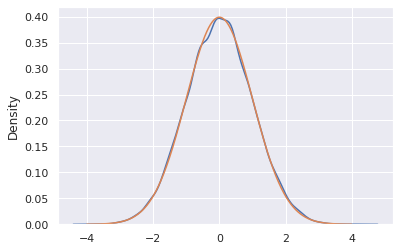

In [14]:
sns.kdeplot(samples)
xx = np.arange(-4, 4, 0.01)
yy = scipy.stats.norm.pdf(xx)
sns.lineplot(x=xx, y=yy)

Now we will use HMC with the contraceptive data from before. First we must specify a suitable model for this data. Note that $n_i$ women of age $z_i$ were asked if they use contraceptives ($n_i$'s in column 'total', $z_i$'s in column 'age'). We let $y_i$ be the number of women of age $z_i$ using contraceptives and assume that $y_i$ is binomially distributed i.e. $$y_i \sim Bin(n_i, p_i)$$ 
where $p_i = \Phi(t_i)$ with $t_i = \beta_0 + \beta_1z_i$ . Here $\Phi$ denotes the cumulative distribution function of the standard normal. This model is referred to as a probit model.

With the model specified we seek to find the values of the parameters $\beta_0$ and $\beta_1$, which we will achieve by using the Hamiltonian Monte Carlo algorithm to obtain samples from our posterior distribution. We will use uninformative normal priors with mean 0 and standard deviation 10 for both parameters. Hence the posterior density satisfies \begin{align} \pi(\beta_0, \beta_1 | y) &\propto \frac{1}{10\sqrt{2\pi}} e^{-\frac{\beta_0^2}{200}}\frac{1}{10\sqrt{2\pi}} e^{-\frac{\beta_1^2}{200}}\prod_{i=1}^n \mathbb{P}(y_i|\beta_0, \beta_1) \\ &\propto e^{-\frac{\beta_0^2}{200}}e^{-\frac{\beta_1^2}{200}}\prod_{i=1}^n\mathbb{P}(y_i|\beta_0, \beta_1). \end{align}
Our function U, given by the negative log of this target density is $$ \frac{\beta_0^2}{200} + \frac{\beta_1^2}{200} - \sum_{i=1}^n \log\mathbb{P}(y_i|\beta_0, \beta_1).$$ Now we will find the gradient of this, first with respect to $\beta_0$. First we replace the $\mathbb{P}$ term with the pmf of the binomial distribution: \begin{align} &\frac{\beta_0^2}{200} + \frac{\beta_1^2}{200} - \sum_{i=1}^n \log \left[{n_i \choose y_i}\Phi(\beta_0 + \beta_1z_i)^{y_i}[1-\Phi(\beta_0 + \beta_1z_i)^{n_i-y_i}\right]\\ = &\frac{\beta_0^2}{200} + \frac{\beta_1^2}{200} - \sum_{i=1}^n \log {n_i \choose y_i}+y_i\log\Phi(\beta_0 + \beta_1z_i)+(n_i-y_i)\log[1-\Phi(\beta_0 + \beta_1z_i)].\end{align} Now differentiating with repect to $\beta_0$ we have
\begin{align}&\frac{\partial}{\partial \beta_0}\left[\frac{\beta_0^2}{200} + \frac{\beta_1^2}{200} - \sum_{i=1}^n \log {n_i \choose y_i}+y_i\log\Phi(\beta_0 + \beta_1z_i)+(n_i-y_i)\log[1-\Phi(\beta_0 + \beta_1z_i)]\right] \\= &\frac{\beta_0}{100} - \sum_{i=1}^n y_i\frac{\partial}{\partial \beta_0}\log\Phi(\beta_0 + \beta_1z_i) + (n_i-y_i)\frac{\partial}{\partial \beta_0}\log[1-\Phi(\beta_0 + \beta_1z_i)]\\ = &\frac{\beta_0}{100} - \sum_{i=1}^n y_i\frac{\phi(\beta_0+\beta_1z_i)}{\Phi(\beta_0 + \beta_1z_i)} + (y_i-n_i)\frac{\phi(\beta_0+\beta_1z_i)}{1-\Phi(\beta_0 + \beta_1z_i)}\end{align}
where $\phi()$ is the pdf of the standard normal. Similar calculations yields for the derivative with respect to $\beta_1$: $$\frac{\beta_1}{100} -\sum_{i=1}^n y_i\frac{z_i\phi(\beta_0+\beta_1z_i)}{\Phi(\beta_0 + \beta_1z_i)}+(y_i-n_i)\frac{z_i\phi(\beta_0+\beta_1z_i)}{1-\Phi(\beta_0 + \beta_1z_i)}.$$

0.6765


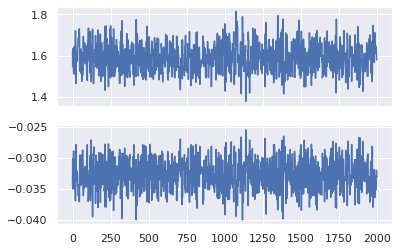

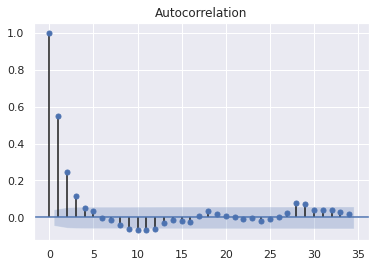

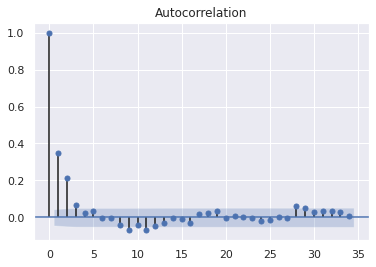

In [17]:
def U(beta):
    """Define potential energy function (minus log of posterior density)."""
    p_i = scipy.stats.norm.cdf(beta[0] + beta[1]*age)
    prob = scipy.stats.binom.pmf(use, total, p_i)
    neg_log_posterior = -sum(np.log(prob)) + beta[0]**2/200 + beta[1]**2/200
    return neg_log_posterior
  
def grad_U(beta):
    """Gradient of U as we found above."""
    t_i = beta[0]+beta[1]*age
    phi = scipy.stats.norm.pdf(t_i)
    Phi = scipy.stats.norm.cdf(t_i)
    a = use * phi / Phi
    b = (use - total) * phi / (1 - Phi)
    d_beta0 = beta[0]/100 - sum(a + b)
    d_beta1 = beta[1]/100 - sum(age * (a + b))
    return d_beta0, d_beta1

# tune epsilon and L appropriately
n_sim, L = 2000, 48
epsilon = np.array([0.017, 0.0013])
current_q = np.array([1.5, -0.03])
samples, n_accepted = HMC(U, grad_U, epsilon, L, current_q, n_sim) 

# show acceptance rate, trace plots and autocorrelations
acc_rate = n_accepted / n_sim
print(acc_rate)
fig, (ax1, ax2) = plt.subplots(2, 1, sharey=False, sharex=True)
ax1.plot(range(n_sim), samples[:,0])
ax2.plot(range(n_sim), samples[:,1])
statsmodels.graphics.tsaplots.plot_acf(samples[:,0]);  
statsmodels.graphics.tsaplots.plot_acf(samples[:,1]);  

Now we have an efficient Markov chain providing us samples from our posterior, we can estimate the posterior means of $\beta_0$ and $\beta_1$.

1.59 -0.0327


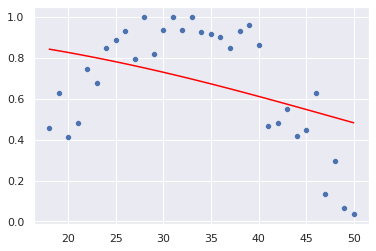

In [21]:
beta_0_hat = round(np.mean(samples[:,0]), 4)
beta_1_hat = round(np.mean(samples[:,1]), 4)
print(beta_0_hat, beta_1_hat)

#Having estimated the parameters, let us visualise the actual data compared
#with the predicted values of the probabilites implied by these estimates
t_i = beta_0_hat + beta_1_hat*age
p_i = scipy.stats.norm.cdf(t_i)
sns.scatterplot(x = age, y = proportion)
plt.plot(age, p_i, color='red')

Clearly the fitted probabilities don't follow the observed probabilities very well. Originally we modelled the probabilities as $p_i = \Phi(\beta_0 + \beta_1z_i)$. The linear relationship inside $\Phi()$ doesn't allow the probabilities to first increase and then decrease with age, as seen in the data. To fix this we slightly amend the model so that $p_i = \Phi(\beta_0 + \beta_1z_i + \beta_2z_i^2)$. 

0.577


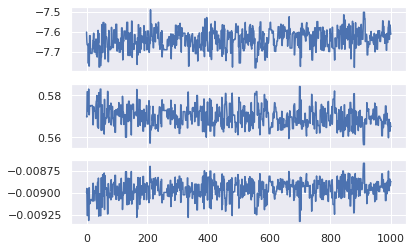

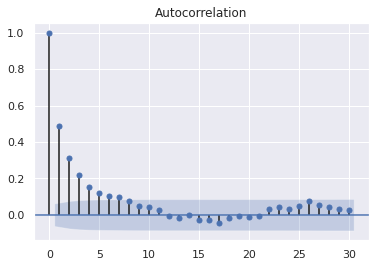

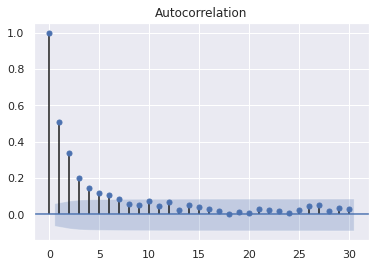

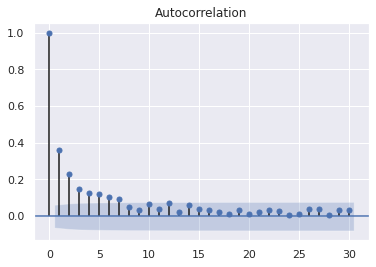

In [25]:
def U(beta):
    """Define new U function (minus log of posterior density)."""
    p_i = scipy.stats.norm.cdf(beta[0] + beta[1]*age + beta[2]*age**2)
    prob = scipy.stats.binom.pmf(use, total, p_i)
    neg_log_posterior = -sum(np.log(prob)) + beta[0]**2/200 + beta[1]**2/200 + beta[2]**2/200 
    return neg_log_posterior
  
def grad_U(beta):
    """Gradient of new U."""
    t_i = beta[0] + beta[1]*age + beta[2]*age**2
    phi = scipy.stats.norm.pdf(t_i)
    Phi = scipy.stats.norm.cdf(t_i)
    a = use * phi / Phi
    b = (use - total) * phi / (1 - Phi)
    d_beta0 = beta[0]/100 - sum(a + b)
    d_beta1 = beta[1]/100 - sum(age * (a + b))
    d_beta2 = beta[2]/100 - sum(age**2 * (a + b))
    return d_beta0, d_beta1, d_beta2

# tune epsilon and L appropriately 
n_sim, L, current_q = 1000, 580, np.array([-7.6, 0.57, -0.009])
epsilon = np.array([0.002, 0.0001, 0.00003])
samples, n_accepted = HMC(U, grad_U, epsilon, L, current_q, n_sim) 

# show acceptance rate, trace plots and autocorrelations
acc_rate = n_accepted / n_sim
print(acc_rate)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=False, sharex=True)
ax1.plot(range(n_sim), samples[:,0])
ax2.plot(range(n_sim), samples[:,1])
ax3.plot(range(n_sim), samples[:,2])
statsmodels.graphics.tsaplots.plot_acf(samples[:,0]);  
statsmodels.graphics.tsaplots.plot_acf(samples[:,1]);
statsmodels.graphics.tsaplots.plot_acf(samples[:,2]);    

We estimate the posterior expectations of $\beta_0$, $\beta_1$, $\beta_2$ and plot the probabilities implied by these estimates against the observed probabilities. 

-7.63624 0.57 -0.00896


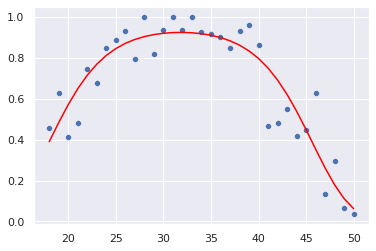

In [26]:
beta_0_hat = round(np.mean(samples[:,0]), 5)
beta_1_hat = round(np.mean(samples[:,1]), 5)
beta_2_hat = round(np.mean(samples[:,2]), 5)
print(beta_0_hat, beta_1_hat, beta_2_hat)
t_i = beta_0_hat + beta_1_hat*age + beta_2_hat*age**2
p_i = scipy.stats.norm.cdf(t_i)
sns.scatterplot(x = age, y = proportion)
plt.plot(age, p_i, color='red')

It is very clear looking at this plot that this model is much better than the original. However for the sake of being rigorous we will use a more concrete method to show the difference in quality of the 2 models. In particular, we will calculate the Bayesian information criterion (BIC) for the 2 models. It is defined as $$\text{BIC} = k\log n - 2\log L(\hat{\beta})$$ where k is the number of parameters in the model, n the number of data points and $L(\hat{\beta})$ the value of the likelihood function evaluated at the maximum likelihood estimate. 

In [33]:
# to calculate BIC we first need to find the MLEs for both of the models
def neg_log_lik_1(beta):
    p_i = scipy.stats.norm.cdf(beta[0] + beta[1]*age)
    prob = scipy.stats.binom.pmf(use, total, p_i)
    negative_log_likelihood = -sum(np.log(prob))
    return negative_log_likelihood

x0 = [0, 0]  
opt1 = scipy.optimize.minimize(neg_log_lik_1, x0, method='BFGS')

def neg_log_lik_2(beta):
    p_i = scipy.stats.norm.cdf(beta[0] + beta[1]*age + beta[2]*age**2)
    prob = scipy.stats.binom.pmf(use, total, p_i)
    negative_log_likelihood = -sum(np.log(prob))
    return negative_log_likelihood

x0 = [0, 0, 0]
opt2 = scipy.optimize.minimize(neg_log_lik_2, x0, method='BFGS')

BIC1 = 2*np.log(33) + 2*opt1.fun
BIC2 = 3*np.log(33) + 2*opt2.fun
print(f'BIC1 = {BIC1:.1f} \nBIC2 = {BIC2:.1f}')

BIC1 = 420.6 
BIC2 = 180.6


The BIC for the second model is much smaller hence confirming it is the more appropriate model for the data.

We are interested in finding the age at which the use of contraceptives is maximal. To do this we must maximise $\Phi(\beta_0 + \beta_1z + \beta_2z^2)$. Since the CDF of the standard normal is strictly increasing this is equivalent to maximising the quadratic function. Differentiating wrt $z$ gives $2\beta_2z + \beta_1$. Setting to 0 and solving for $z$ gives $z = \frac{-\beta_1}{2\beta_2}$.

z_max = 31.8


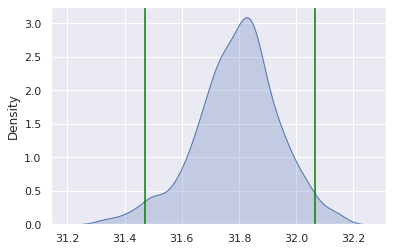

In [36]:
print(f'z_max = {-beta_1_hat/(2*beta_2_hat):.1f}')
# we can also find the posterior distribution of the age of maximal use using 
# our posterior samples. We plot its distribution and also show the upper and 
# lower bounds of the 95% credible interval
ss = -samples[:,1]/(2*samples[:,2])
sns.kdeplot(ss, fill=True) 
low = np.quantile(ss, 0.025)
upp = np.quantile(ss, 0.975)
plt.axvline(low, color='green')
plt.axvline(upp, color='green')

Finally we use the same model with PyMC3 to check we obtain similar results.

In [ ]:
model = pm.Model()
with model:
    beta0 = pm.Normal("beta0", mu=0, sd=10)
    beta1 = pm.Normal("beta1", mu=0, sd=10)
    beta2 = pm.Normal("beta2", mu=0, sd=10)
  
    def phi(x):
        """Probit transformation."""
        import theano.tensor as t
        return 0.5 * (1 + t.erf(x / t.sqrt(2)))

    t = beta0 + beta1*age + beta2*age**2
    Y = pm.Binomial("Y", n=total, p=phi(t), observed=use)
    trace = pm.sample(1000,start={'beta0':-7.6, 'beta1':0.57, 'beta2':-0.009})

In [53]:
with model:
    display(az.summary(trace)) 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-7.662,0.616,-8.826,-6.539,0.035,0.025,320.0,315.0,1.01
beta1,0.572,0.040,0.496,0.644,0.002,0.002,315.0,319.0,1.01
beta2,-0.009,0.001,-0.010,-0.008,0.000,0.000,321.0,339.0,1.01


Recall our estimates of the means: $\beta_0=-7.636$, $\beta_1=0.57$, $\beta_2=-0.009$. We can see that our algorithm yields very similar results to PyMC3. 